## Student Loan Calculator

This is revisiting a set of calculations I have previously done in excel in order to become familiar with Pandas


In [141]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [191]:
df = pd.DataFrame(columns=['Year', 'Salary', 'Tax', 'Outstanding_Loan', 'Forced Repayment', 'Voluntary Repayment', 'Net Salary', 'Loan Interest'])
df.Year = range(30)
df.head()

,Year,Salary,Tax,Outstanding_Loan,Forced Repayment,Voluntary Repayment,Net Salary,Loan Interest
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
parameters = {'initial_salary' : 36000,
              'initial_loan' : 43186.95,
              'inflation' : 0.0202,
              'low_tax_rate' : 0.2,
              'low_tax_band' : 50000,
              'mid_tax_rate' : 0.4,
              'mid_tax_band' : 150000,
              'high_tax_rate' : 0.45,
              'repay rate' : 0.09,
              'repay_thresh' : 26568
             }

df.at[0, 'Salary'] = parameters['initial_salary']
df.head()

,Year,Salary,Tax,Outstanding_Loan,Forced Repayment,Voluntary Repayment,Net Salary,Loan Interest
0,0,36000,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
yearly_salary = np.zeros(len(df))
yearly_salary[0] = parameters['initial_salary']
for i in range(len(yearly_salary)-1):
    yearly_salary[i+1] = yearly_salary[i] * (1+parameters['inflation'])
    
    ## come back and make this salary boost customizeable
    if i % 5 == 0 and i > 3:
        yearly_salary[i+1] += 3000

df.Salary = yearly_salary


In [194]:
## should really fix this to take account of all three tax bands
df.Tax = np.where(df['Salary'] >= 40000, df.Salary * 0.4, df.Salary * 0.2)

In [195]:
df.head()

,Year,Salary,Tax,Outstanding_Loan,Forced Repayment,Voluntary Repayment,Net Salary,Loan Interest
0,0,36000.000000,7200.000000,NaN,NaN,NaN,NaN,NaN
1,1,36727.200000,7345.440000,NaN,NaN,NaN,NaN,NaN
2,2,37469.089440,7493.817888,NaN,NaN,NaN,NaN,NaN
3,3,38225.965047,7645.193009,NaN,NaN,NaN,NaN,NaN
4,4,38998.129541,7799.625908,NaN,NaN,NaN,NaN,NaN


In [196]:
df.loc[0, 'Outstanding_Loan'] = parameters['initial_loan']

In [215]:
# setup a loop to populate the dataframe with dependent values
for i in range(len(df)):
    # sort out how much interest is charged each year
    df.loc[i, 'Loan Interest'] = 1.02
    
    # setup how much we want to repay voluntarily
    df.loc[i, 'Voluntary Repayment'] = 0
    
    # calculate the mandatory repayment amount if it's non negative
    if df.loc[i, 'Salary'] > parameters['repay_thresh']:
        df.loc[i, 'Forced Repayment'] = (df.loc[i, 'Salary'] - parameters['repay_thresh']) * parameters['repay rate']
    else:
        df.loc[i, 'Forced Repayment'] = 0
    
    # multiply loan by interest rate
    df.loc[i, 'Outstanding_Loan'] *= df['Loan Interest'][i]
    # reduce debt by amount repaid
    if df.Outstanding_Loan[i] > 0:
        if df.loc[i, 'Outstanding_Loan'] - df['Forced Repayment'][i] - df['Voluntary Repayment'][i] > 0:
            df.loc[i+1, 'Outstanding_Loan'] = df.loc[i, 'Outstanding_Loan'] - df['Forced Repayment'][i] - df['Voluntary Repayment'][i]
        else:
            df.loc[i, 'Forced Repayment'] = df.loc[i, 'Outstanding_Loan'] - df['Voluntary Repayment'][i]
            df.loc[i+1, 'Outstanding_Loan'] = 0
    else:
        df.loc[i, 'Outstanding_Loan'] = 0
        
    # calculate net salary for the current year by subtracting tax and repayments
    df.loc[i, 'Net Salary'] = df.loc[i, 'Salary'] - df['Tax'][i] - df['Forced Repayment'][i] - df['Voluntary Repayment'][i]
    

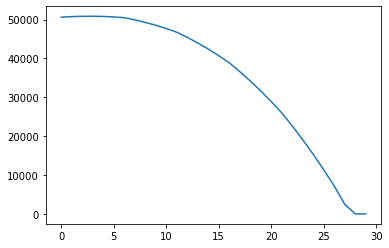

In [218]:
plt.figure()
plt.plot(df.Year, df['Outstanding_Loan'])
plt.show()